In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset_wine.csv')

In [3]:
len(df) # cantidad de filas

6497

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   type                  6497 non-null   object 
 2   fixed acidity         6487 non-null   float64
 3   volatile acidity      6489 non-null   float64
 4   citric acid           6494 non-null   float64
 5   residual sugar        6495 non-null   float64
 6   chlorides             6495 non-null   float64
 7   free sulfur dioxide   6497 non-null   float64
 8   total sulfur dioxide  6497 non-null   float64
 9   density               6497 non-null   float64
 10  pH                    6488 non-null   float64
 11  sulphates             6493 non-null   float64
 12  alcohol               6497 non-null   float64
 13  quality               6497 non-null   int64  
 14  vendor_id             6497 non-null   int64  
dtypes: float64(11), int64

In [5]:
print(df.head())

   Unnamed: 0   type  fixed acidity  volatile acidity  citric acid  \
0           0  white            7.0              0.27         0.36   
1           1  white            6.3              0.30         0.34   
2           2  white            8.1              0.28         0.40   
3           3  white            7.2              0.23         0.32   
4           4  white            7.2              0.23         0.32   

   residual sugar  chlorides  free sulfur dioxide  total sulfur dioxide  \
0            20.7      0.045                 45.0                 170.0   
1             1.6      0.049                 14.0                 132.0   
2             6.9      0.050                 30.0                  97.0   
3             8.5      0.058                 47.0                 186.0   
4             8.5      0.058                 47.0                 186.0   

   density    pH  sulphates  alcohol  quality  vendor_id  
0   1.0010  3.00       0.45      8.8        6        369  
1   0.9940

In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy import stats

In [7]:
print(np.min(df.quality))
print(np.max(df.quality))

3
9


(array([  30.,  216.,    0., 2138.,    0., 2836., 1079.,    0.,  193.,
           5.]),
 array([3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6, 7.2, 7.8, 8.4, 9. ]),
 <a list of 10 Patch objects>)

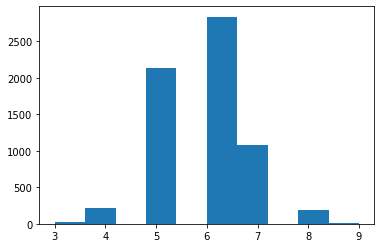

In [8]:
quality = df.quality.to_numpy()
fix, ax1 = plt.subplots(1,1)
ax1.hist(quality)

In [9]:
df["quality_label"] = df.quality.apply(lambda label: 0 if label <= 6 else 1)
print(len(df[df["quality_label"] == 0])) # bad quality 
print(len(df[df["quality_label"] == 1])) # good quality

5220
1277


In [10]:
# clasificación binaria -> modelo tonto -> siempre devolver la clase mayoritaria
# regresion -> modelo totno -> siempre devolver el promedio de tu salida

## Ingeniería de features

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   type                  6497 non-null   object 
 2   fixed acidity         6487 non-null   float64
 3   volatile acidity      6489 non-null   float64
 4   citric acid           6494 non-null   float64
 5   residual sugar        6495 non-null   float64
 6   chlorides             6495 non-null   float64
 7   free sulfur dioxide   6497 non-null   float64
 8   total sulfur dioxide  6497 non-null   float64
 9   density               6497 non-null   float64
 10  pH                    6488 non-null   float64
 11  sulphates             6493 non-null   float64
 12  alcohol               6497 non-null   float64
 13  quality               6497 non-null   int64  
 14  vendor_id             6497 non-null   int64  
 15  quality_label        

In [12]:
# Analicemos la variable tipo
print(df["type"].unique())
type_dummies = pd.get_dummies(df["type"], prefix="type") # -> one hot encoding
type_dummies.info() 

# concatenar esta representación del type al dataset original
dataset = pd.concat([df, type_dummies], axis=1)
dataset.info()

['white' 'red']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   type_red    6497 non-null   uint8
 1   type_white  6497 non-null   uint8
dtypes: uint8(2)
memory usage: 12.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            6497 non-null   int64  
 1   type                  6497 non-null   object 
 2   fixed acidity         6487 non-null   float64
 3   volatile acidity      6489 non-null   float64
 4   citric acid           6494 non-null   float64
 5   residual sugar        6495 non-null   float64
 6   chlorides             6495 non-null   float64
 7   free sulfur dioxide   6497 non-null   float64
 8   total sulfur dioxide  6497 non-null   float64
 9   density   

In [13]:
# Analicemos la vendor_id
print(len(dataset["vendor_id"].unique())) # -> embeddings

500


# Limpiar el dataset removiendo nans

In [14]:
nans = dataset[dataset.isna().sum(axis=1) >= 1]
print(nans.shape)

(34, 18)


In [15]:
dataset = dataset[dataset.isna().sum(axis=1) == 0]
print(dataset.shape)

(6463, 18)


In [16]:
y = dataset["quality_label"]
vendor_id = dataset["vendor_id"]
X = dataset.drop(["Unnamed: 0", "type", "quality", "quality_label", "vendor_id"], axis=1)


## Normalización

In [17]:
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [18]:
print(np.min(X_norm, axis=0))
print(np.max(X_norm, axis=0))

fixed acidity           0.0
volatile acidity        0.0
citric acid             0.0
residual sugar          0.0
chlorides               0.0
free sulfur dioxide     0.0
total sulfur dioxide    0.0
density                 0.0
pH                      0.0
sulphates               0.0
alcohol                 0.0
type_red                0.0
type_white              0.0
dtype: float64
fixed acidity           1.0
volatile acidity        1.0
citric acid             1.0
residual sugar          1.0
chlorides               1.0
free sulfur dioxide     1.0
total sulfur dioxide    1.0
density                 1.0
pH                      1.0
sulphates               1.0
alcohol                 1.0
type_red                1.0
type_white              1.0
dtype: float64


In [19]:
X_norm.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
count,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000,6463.000000
mean,0.282459,0.173059,0.192023,0.074294,0.078166,0.102489,0.252752,0.146283,0.386304,0.174803,0.361279,0.246480,0.753520
std,0.107266,0.109759,0.087501,0.072958,0.058265,0.061663,0.130246,0.057865,0.124535,0.083659,0.172917,0.430995,0.430995
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.214876,0.100000,0.150602,0.018405,0.048173,0.055556,0.163594,0.100636,0.302326,0.117978,0.217391,0.000000,1.000000
50%,0.264463,0.140000,0.186747,0.036810,0.063123,0.097222,0.258065,0.149990,0.379845,0.162921,0.333333,0.000000,1.000000
75%,0.322314,0.213333,0.234940,0.115031,0.093023,0.138889,0.345622,0.190669,0.465116,0.213483,0.478261,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Split

In [20]:
X_norm = X_norm.to_numpy()
y = y.to_numpy()
n = X_norm.shape[0]
print(n)
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.85 * n)]
valid_idx = idx[int(0.85 * n):]
print(len(train_idx))
print(len(valid_idx))

# train -> entrenar tu modelo (80%)
# valid -> encontrar los HPs (10%)
# test -> calcular las metricas finales (10%)

6463
5493
970


In [21]:
X_train = X_norm[train_idx,:]
y_train = y[train_idx]
X_valid = X_norm[valid_idx,:]
y_valid = y[valid_idx]

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(5493, 13)
(5493,)
(970, 13)
(970,)


# NNet sin embeddings

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

In [23]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [24]:
train = MyDataset(X_train, y_train)

In [25]:
len(train)

5493

In [26]:
X0, y0 = train[0]

In [27]:
X0.shape

(13,)

In [28]:
X_train.shape

(5493, 13)

In [29]:
y0

0

In [30]:
valid = MyDataset(X_valid, y_valid)

In [31]:
len(valid)

970

In [32]:
print(X0)

[0.30578512 0.34       0.13253012 0.01840491 0.12126246 0.14583333
 0.12442396 0.15191826 0.29457364 0.11235955 0.17391304 1.
 0.        ]


In [33]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [34]:
batch_1 = next(iter(train_dataloader))

In [35]:
type(batch_1)

list

In [36]:
len(batch_1)

2

In [37]:
type(batch_1[0])

torch.Tensor

In [38]:
print(batch_1[0].shape) # -> 64 filas de X_train (dataset de entrenamiento)

torch.Size([64, 13])


In [39]:
print(batch_1[1].shape) # -> 64 filas de y_train (label)

torch.Size([64])


In [40]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=13, out_features=100, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=100, out_features=50, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=50, out_features=1, bias=True)

    def forward(self, x): # x.shape -> 64 x 13
        x = self.linear_1(x) # x.shape -> 64 x 100 
        #print(x.shape)
        x = self.relu_1(x) # x.shape -> 64 x 100
        #print(x.shape)
        x = self.linear_2(x) # x.shape -> 64 x 50
        #print(x.shape)
        x = self.relu_2(x) # x.shape -> 64 x 50
        #print(x.shape)
        x = self.output(x) # x.shape -> 64 x 1
        return x

In [41]:
nnet = NNet()

In [42]:
x_batch = next(iter(train_dataloader))[0]
print(type(x_batch))
x_batch = x_batch.float()
y_batch = nnet(x_batch)
print(x_batch.shape)
print(y_batch.shape)

<class 'torch.Tensor'>
torch.Size([64, 13])
torch.Size([64, 1])


In [43]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

In [44]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cuda:0


In [45]:
nnet.to(device)

loss_list = []
train_auc = []
for epoch in range(100):

    running_loss = 0
    running_y_score = []
    running_y_label = []
    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet(X_batch).reshape(-1)
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())  
        running_y_label += list(Y_batch.detach().cpu().numpy()) 

    # metrics
    loss_list.append(running_loss)
    fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    auc = metrics.auc(fpt, tpr)
    train_auc.append(auc)
    print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")


Epoch 0 | Training loss: 2859.8209953308105 | AUC: 0.5563575718331356
Epoch 1 | Training loss: 2473.2619819641113 | AUC: 0.734933855537971
Epoch 2 | Training loss: 2292.2297191619873 | AUC: 0.7782239946198468
Epoch 3 | Training loss: 2223.465284347534 | AUC: 0.7920670689641299
Epoch 4 | Training loss: 2188.203193664551 | AUC: 0.8003808118593757
Epoch 5 | Training loss: 2184.0359830856323 | AUC: 0.8021671379523994
Epoch 6 | Training loss: 2157.2280082702637 | AUC: 0.8090002164088745
Epoch 7 | Training loss: 2146.4051790237427 | AUC: 0.8113722440160405
Epoch 8 | Training loss: 2136.721487045288 | AUC: 0.8143167387394331
Epoch 9 | Training loss: 2134.5286598205566 | AUC: 0.8146673973465984
Epoch 10 | Training loss: 2129.2716035842896 | AUC: 0.8155726301640093
Epoch 11 | Training loss: 2121.1023359298706 | AUC: 0.8173085596697711
Epoch 12 | Training loss: 2119.2306060791016 | AUC: 0.8179929368547703
Epoch 13 | Training loss: 2116.8167247772217 | AUC: 0.8186045777888264
Epoch 14 | Training 

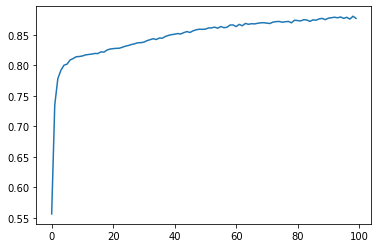

In [46]:
fig, ax1 = plt.subplots(1,1)
x = range(0, len(train_auc))
ax1.plot(x, train_auc)

# NNet with embeddings

In [47]:
unique = np.unique(vendor_id)
index = np.arange(0, len(unique))
vendor_id_to_index = {key: value for key, value in zip(unique, index)}

In [48]:
vendors_idx = np.array([vendor_id_to_index[vendor] for vendor in vendor_id])

In [49]:
print(max(vendors_idx))
print(min(vendors_idx))

499
0


In [50]:
class CustomDatasetWithEmb(Dataset):

    def __init__(self, X, vendors_idx, y):
        super().__init__()
        self.X = X
        self.vendors_idx = vendors_idx
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.vendors_idx[idx], self.y[idx]

In [51]:
vendors_index_train = vendors_idx[train_idx]  
vendors_index_val = vendors_idx[valid_idx]
train = CustomDatasetWithEmb(X_train, vendors_index_train, y_train)
valid = CustomDatasetWithEmb(X_valid, vendors_index_val, y_valid)

In [52]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [53]:
class NNetWithEmbeddings(torch.nn.Module):

    def __init__(self, number_of_vendors, d):
        super().__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=number_of_vendors, embedding_dim=d)
        self.linear_1 = torch.nn.Linear(in_features=(13+d), out_features=100, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=100, out_features=50, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=50, out_features=1, bias=True)

    def forward(self, x, vendor_idx):
        vendor_emb = self.embedding(vendor_idx) # (64, d)

        final_input = torch.cat([x, vendor_emb], dim=1) # (64, 13+d)

        x = self.linear_1(final_input) 
        x = self.relu_1(x)
        x = self.linear_2(x)
        x = self.relu_2(x)        
        x = self.output(x) 
        return x


In [54]:
nnet2 = NNetWithEmbeddings(number_of_vendors=500, d=8)
optimizer = torch.optim.Adam(nnet2.parameters(), lr=0.001)
loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

In [55]:
print(nnet)

NNet(
  (linear_1): Linear(in_features=13, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (relu_2): ReLU()
  (output): Linear(in_features=50, out_features=1, bias=True)
)


In [56]:
print(nnet2)

NNetWithEmbeddings(
  (embedding): Embedding(500, 8)
  (linear_1): Linear(in_features=21, out_features=100, bias=True)
  (relu_1): ReLU()
  (linear_2): Linear(in_features=100, out_features=50, bias=True)
  (relu_2): ReLU()
  (output): Linear(in_features=50, out_features=1, bias=True)
)


In [57]:
nnet = nnet2

nnet.to(device)

loss_list = []
train_auc = []
for epoch in range(100):

    running_loss = 0
    running_y_score = []
    running_y_label = []

    #### TRAINING ####

    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, vendor_idx_batch, y_batch = data 
        X_batch = X_batch.to(device).float()
        vendor_idx_batch = vendor_idx_batch.to(device)
        Y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()
        y_batch_score = nnet(X_batch, vendor_idx_batch).reshape(-1)
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())  
        running_y_label += list(Y_batch.detach().cpu().numpy()) 

    # metrics
    loss_list.append(running_loss)
    fpt, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    auc = metrics.auc(fpt, tpr)
    train_auc.append(auc)
    print(f"Epoch {epoch} | Training loss: {running_loss} | AUC: {auc}")

    #### VALIDATION ####



Epoch 0 | Training loss: 2844.5662593841553 | AUC: 0.5614768486971635
Epoch 1 | Training loss: 2437.4666652679443 | AUC: 0.7371794681762491
Epoch 2 | Training loss: 2126.1501331329346 | AUC: 0.8306182348404736
Epoch 3 | Training loss: 1618.8515930175781 | AUC: 0.9077160139602782
Epoch 4 | Training loss: 1129.5530052185059 | AUC: 0.9540799213643838
Epoch 5 | Training loss: 799.3042089939117 | AUC: 0.9757376429897289
Epoch 6 | Training loss: 586.6471501588821 | AUC: 0.9861324684883692
Epoch 7 | Training loss: 408.211905002594 | AUC: 0.9927265866560848
Epoch 8 | Training loss: 310.28957176208496 | AUC: 0.9954363560980506
Epoch 9 | Training loss: 237.7541046142578 | AUC: 0.9972046834099094
Epoch 10 | Training loss: 174.39720633625984 | AUC: 0.9985831782967732
Epoch 11 | Training loss: 142.73215046525002 | AUC: 0.9988942395853758
Epoch 12 | Training loss: 107.85589319467545 | AUC: 0.9993001650382358
Epoch 13 | Training loss: 88.18795971572399 | AUC: 0.9995072568968153
Epoch 14 | Training lo

In [ ]:
#### VALIDATION ####
    nnet.eval()
    with torch.no_grad():

        for i, data in enumerate(valid_dataloader):

            # TODO: pasos para acumular validation loss
            # TODO: pasos para acumular y_score and y

        # TODO: pasos para calcular las metrics (AUC) 

        
# TODO
# PLOT train loss and valid loss vs epochs
# PLOT train auc and valid auc vs epochs